# Choosing between earlier and later expressions, given two groups' observed interactions

December 2024

In [1]:
# import jax
import jax.numpy as jnp
# from jax import lax
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

import data_tools
import model_tools
import utils

from enums import *

sns.set_theme('talk')

In [2]:
data = data_tools.get_data(expt_type=ExptTypes.EarlierLater)
tangram_info = data_tools.get_tangram_info(expt_type=ExptTypes.EarlierLater)
data_organized = data_tools.make_data_matrices(data, expt_type=ExptTypes.EarlierLater)


In [3]:
tangram_info

,tangram_set,counterbalance,tangram_type,tangram
0,0,a,GroupSpecific,A
1,0,a,GroupSpecific,D
2,0,a,GroupSpecific,H
3,0,a,Shared,B
4,0,a,Shared,C
5,0,a,Shared,L
6,0,b,GroupSpecific,B
7,0,b,GroupSpecific,C
8,0,b,GroupSpecific,L
9,0,b,Shared,A


In [4]:
alphas = jnp.array([1]) # jnp.arange(0, 5, 0.1)
w_rs = jnp.arange(0, 5, 0.1)
w_ss = jnp.arange(0, 5, 0.1)
w_cs = jnp.arange(0, 5, 0.1)

In [5]:
params_list_no_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=jnp.array([0]), w_cs=w_cs
)

params_list_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=w_rs, w_cs=w_cs
)

In [6]:
best_params_no_social, best_nll_no_social, _ = model_tools.grid_search_nll(data_organized, tangram_info, params_list=params_list_no_social, expt_type=ExptTypes.EarlierLater)
best_params_social, best_nll_social, _ = model_tools.grid_search_nll(data_organized, tangram_info, params_list=params_list_social, expt_type=ExptTypes.EarlierLater)

In [7]:
print(f"Best params no social: {best_params_no_social}")
print(f"NLL no social: {best_nll_no_social}")
print(f"Best params social: {best_params_social}")
print(f"NLL social: {best_nll_social}")

Best params no social: [1.  1.9 0.  0.7]
NLL no social: 1380.377685546875
Best params social: [1.  1.6 0.3 0.6]
NLL social: 1377.65576171875


Get model predictions (probability of later utterance)

In [8]:
preds_no_social = model_tools.get_model_preds(*best_params_no_social, expt_type=ExptTypes.EarlierLater)
preds_social = model_tools.get_model_preds(*best_params_social, expt_type=ExptTypes.EarlierLater)

Put the model predictions in a dataframe

In [9]:
# Put it in a dataframe
df_preds = pd.DataFrame(columns=["type", "condition", "tangram_type", "p_earlier"])
rows = []
for condition in Conditions:
    for tangram_type in TangramTypes:
        rows.append(
            {
                "type": "no_social",
                "condition": condition.name,
                "tangram_type": tangram_type.name,
                "p_earlier": 1 - preds_no_social[condition, tangram_type],
            }
        )

for condition in Conditions:
    for tangram_type in TangramTypes:
        rows.append(
            {
                "type": "social",
                "condition": condition.name,
                "tangram_type": tangram_type.name,
                "p_earlier": 1 - preds_social[condition, tangram_type],
            }
        )

df_preds = pd.concat([df_preds, pd.DataFrame(rows)], ignore_index=True)

# remove jax stuff
df_preds["p_earlier"] = df_preds["p_earlier"].apply(lambda x: x.item())
df_preds

,type,condition,tangram_type,p_earlier
0,no_social,ReferEither,Shared,0.331812
1,no_social,ReferEither,GroupSpecific,0.550169
2,no_social,ReferOne,Shared,0.331812
3,no_social,ReferOne,GroupSpecific,0.331812
4,no_social,SocialOne,Shared,0.331812
5,no_social,SocialOne,GroupSpecific,0.331812
6,social,ReferEither,Shared,0.354344
7,social,ReferEither,GroupSpecific,0.542701
8,social,ReferOne,Shared,0.354344
9,social,ReferOne,GroupSpecific,0.354344


Plot

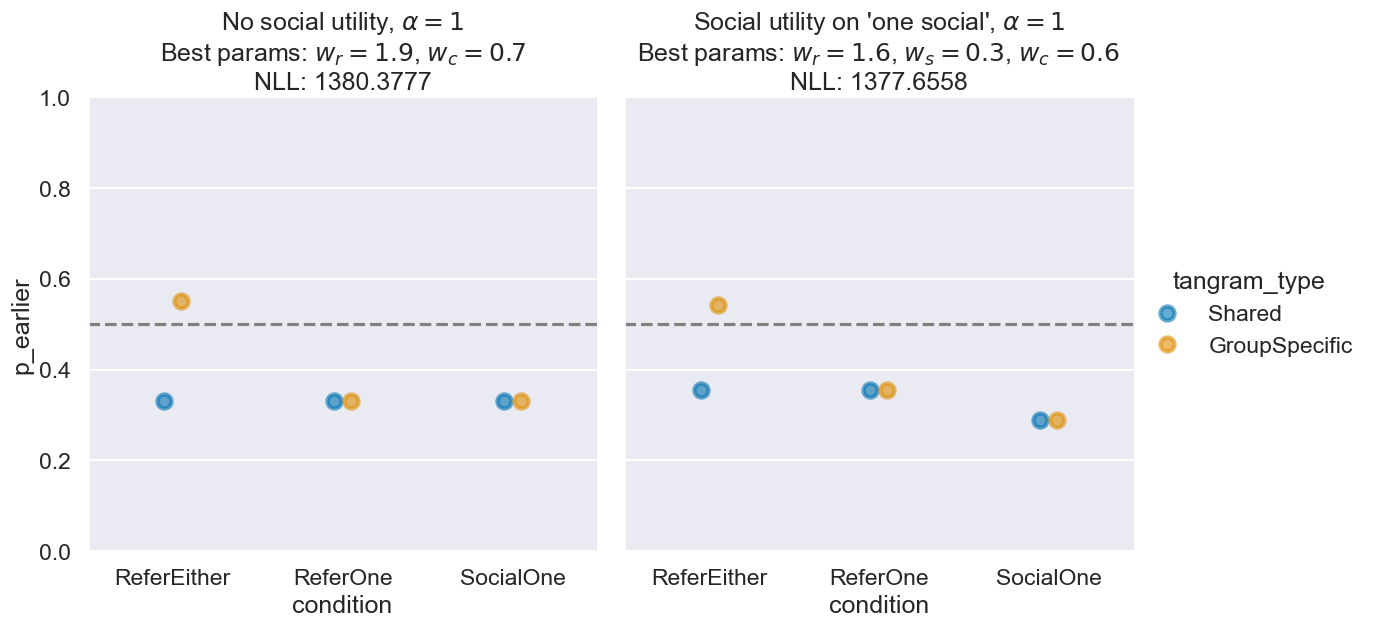

In [10]:
g = sns.catplot(
    data=df_preds,
    x="condition",
    y="p_earlier",
    hue="tangram_type",
    col="type",
    kind="point",
    height=6,
    aspect=1,
    palette="colorblind",
    dodge=0.1,
    alpha=0.6,
    linestyle="none",
)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

# add an extra title to each of the plots
titles = [
    f"No social utility, $\\alpha=1$\nBest params: $w_r={best_params_no_social[1]:.1f}$, $w_c={best_params_no_social[3]:.1f}$\nNLL: {best_nll_no_social:.4f}",
    f"Social utility on 'one social', $\\alpha=1$\nBest params: $w_r={best_params_social[1]:.1f}$, $w_s={best_params_social[2]:.1f}$, $w_c={best_params_social[3]:.1f}$\nNLL: {best_nll_social:.4f}",
]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)  # add padding to the title
plt.show()

Do likelihood ratio test

In [11]:
# Test statistic
lr_stat = 2 * (best_nll_no_social - best_nll_social)

# Degrees of freedom: number of additional parameters in the "social" model
df = 1  # w_s is the additional parameter

p_value = chi2.sf(lr_stat, df)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value}")

Likelihood Ratio Test Statistic: 5.44384765625
Degrees of Freedom: 1
P-value: 0.019637365119203092
